### 4.5 正则化线性模型
减少过拟合的一个好方法就是对模型进行正则化（即约束模型）：它拥有的自由度越少，则过拟合数据的难度就越大。

正则化多项式模型的一种简单方法是减少多项式的次数。

对于线性模型，正则化通常是通过约束模型的权重实现的。

#### 4.5.1 岭回归
岭回归也称为ikhonov正则化，是线性回归的正则化版本，将等于$\alpha \sum_{i=1}^n \theta_i^2$的正则化添加到loss函数。这迫使学习算法不仅拟合数据，而且还使模型权重尽可能的小。

**注意尽在训练期间将正则化添加到成本函数中，训练完模型后，你要使用非正则话的性能度量来评估模型的性能**

超参数$\alpha$控制要对模型进行正则化的程度。如果$\alpha = 0$，则岭回归仅是线性回归。如果$\alpha$非常大，则所有的权重最终接近于零，结果是一条经过数据均值的平线。公式4-8是岭回归的成本函数:

$$
J(\theta) = MSE(\theta) + \alpha \frac{1}{2} \sum_{i=1}^n \theta_i^2 
$$

**注意**，偏置项$theta_0$没有正则化（总是从$i=1$开始，而不是0）


在执行岭回归之前缩放数据（例如使用`StandardScaler`）很重要，因为它对输入特征的缩放敏感。大多数正则化模型都需要如此。

**闭式解的岭回归**  

$$
\hat{\theta} = (X^T X + \alpha A)^{-1}X^T y
$$

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [2]:
X = 6 * np.random.rand(100, 1)
y = 0.5 * (X ** 2) + 0.9 * X + 2 + np.random.randn(100, 1)

In [3]:
# 闭式解
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.47907787]])

In [4]:
# 梯度下降
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])


array([4.66717527])

#### 4.5.2 Lasso回归

线性回归的另外一种正则化叫做最小绝对收缩和选择算子回归(Least Absolute Shrinkage and Selection Oprator Regression，简称Lasso回归).与岭回归一样，它也是向成本函数添加一个正则项，但是它增加的是权重向量的$l_1$范数，而不是$l_2$范数的平方的一半。4-10：Lasso回归的成本函数:

$$
J(\theta) = MSE(\theta) + \alpha \sum_{i=1}^n |\theta_i|
$$

**Lasso回归的一个重要特点是他倾向于完全消除最不重要的特征的权重。**

In [5]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.51439503])

In [6]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty='l1')
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

array([4.66188287])

#### 4.5.3 弹性网络
弹性网络介于岭回归与Lasso回归之间的中间地带。弹性网络成长函数为:

$$
J(\theta) = MSE(\theta) + r \alpha \sum_{i=1}^n |\theta_i| + \frac{1-r}{2}\alpha \sum_{i=1}^n \theta_i^2
$$

**那么什么时候使用普通的线性回归（即不进行任何正则化）、岭、Lasso或弹性网络呢？**

- 通常来说，有正则化——哪怕很小，总比没有更可取一些。所以大多数情况下，你应该避免使用纯线性回归

- 岭回归是个不错的默认选择，但是如果你觉得实际用到的特征只有少数几个，那就更应该倾向于Lassso回归或者是弹性网络，因为他们会将无用特征的权重将为零

- 一般而言，弹性网络优于Lasso回归，因为当特征数量超过训练实例数量，又或是几个特征是强相关时，Lasso的表现可能非常不稳定

In [7]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.59996076])

#### 4.5.4 提前停止
提前停止法是在验证误差达到最小值时停止训练，这也被归类为一个与众不同的正则化方法🤦‍♀️

使用随机和小批量梯度下降时，曲线不是那么平滑，可能很难知道你是否达到了最小值。一种解决方案是仅在验证误差超过最小值一段时间后停止（当你确信模型不会做得更好时），然后回滚模型参数到验证误差最小的位置。

In [8]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [9]:
#prepare the data
from sklearn.model_selection import train_test_split
X = 6 * np.random.rand(10000, 1)
y = 0.5 * (X ** 2) + 0.9 * X + 2 + np.random.randn(10000, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('std_scaler', StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=10, tol=-np.infty, warm_start=True, penalty='l2', learning_rate='constant', eta0=0.005)

mini_val_error = float('inf')
val_errors = []
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    val_errors.append(val_error)

    if val_error < mini_val_error:
        mini_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

print("mini_val_error: {}\nbest_epoch:{}".format(mini_val_error, best_epoch))


mini_val_error: 0.9668706683581825
best_epoch:980


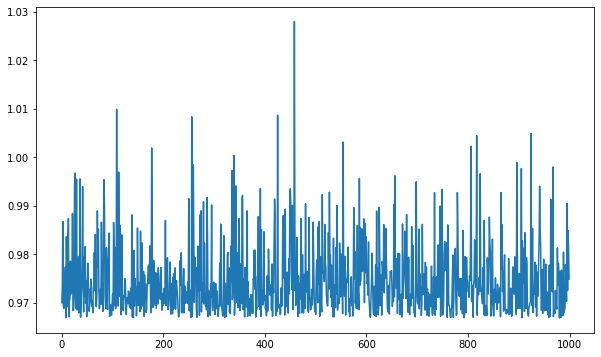

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1000), val_errors)
plt.show()

**在使用`warm_start=True`的情况下，当调用`fit()`方法时，它将在停止的地方继续训练，而不是从头开始**